<a href="https://colab.research.google.com/github/vsaathwika0904/hds5210-2023/blob/main/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install plotly

# Healthcare Data Analysis: Diabetes and Kidney Disease

This notebook presents a comprehensive analysis of two healthcare datasets: one focusing on diabetes indicators and the other on kidney disease. Our goal is to explore the relationship between various health indicators and these diseases, understand patterns, and derive insights that could be beneficial in healthcare management and policy making.

We'll approach this by merging, aggregating, transforming, and visualizing the data, followed by predictive modeling to understand the factors influencing these diseases.

## 1. Data Retrieval & Manipulation

In this section, we focus on retrieving and preparing the data for our analysis. This involves loading the datasets, understanding their structure, and performing initial data manipulation tasks such as merging. Efficient data handling is crucial for the success of our subsequent analysis steps.

### 1-1. Data Sources

The analysis is based on two datasets:
1. **Diabetes Health Indicators Dataset**: This dataset, derived from the BRFSS survey, contains various health indicators related to diabetes.

  https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

2. **Kidney Disease Dataset**: This dataset provides insights into various factors related to kidney disease.

  https://www.kaggle.com/datasets/mansoordaku/ckdisease


### 1-2. Datasets Description

The Diabetes dataset contains indicators such as blood pressure (transformed into binary values), BMI, smoking status, etc., while the Kidney disease dataset includes more detailed blood pressure readings along with other health indicators. Understanding the nuances in these datasets is key to accurate analysis.

### 1-3. Data Loading and Merging

Loading the datasets is the first step in our data manipulation process. We then proceed to merge these datasets. In this analysis, we merge the datasets based on age and blood pressure indicators. The blood pressure values in the kidney dataset are transformed into binary values to match the format in the diabetes dataset, facilitating a meaningful merge.

In [2]:
import pandas as pd

# Load datasets
diabetes_dataset = "https://drive.google.com/uc?id=1vm6-JzKRA1_bq1yGdTzAbpZXZvoOLCYF"
kidney_dataset = "https://drive.google.com/uc?id=1BVQEQAzMT2sfMQDQIGbPARJ67xX0b22_"

diabetes_data = pd.read_csv(diabetes_dataset)
kidney_data = pd.read_csv(kidney_dataset)

#Converting columns to lower case to avoid discrepancies while merging
diabetes_data.columns = diabetes_data.columns.str.lower()
kidney_data.columns = kidney_data.columns.str.lower()

# Preliminary Data Processing
# Converting blood pressure (bp) values in kidney dataset to binary for compatibility with diabetes dataset
kidney_data['bp_binary'] = kidney_data['bp'].apply(lambda x: 1 if x > 120 else 0)

# Merging datasets on 'age' and 'bp_binary'
merged_data = pd.merge(diabetes_data, kidney_data, how='inner', left_on=['age', 'highbp'], right_on=['age', 'bp_binary'])

# Displaying first few rows of the merged dataset
print(merged_data.head())

   diabetes_binary  highbp  highchol  cholcheck   bmi  smoker  stroke  \
0              0.0     0.0       0.0        1.0  29.0     1.0     0.0   
1              0.0     0.0       0.0        1.0  29.0     1.0     0.0   
2              0.0     0.0       0.0        1.0  29.0     1.0     0.0   
3              0.0     0.0       0.0        1.0  20.0     0.0     0.0   
4              0.0     0.0       0.0        1.0  20.0     0.0     0.0   

   heartdiseaseorattack  physactivity  fruits  ...    wc   rc  htn    dm  cad  \
0                   0.0           1.0     1.0  ...  6700  NaN   no    no   no   
1                   0.0           1.0     1.0  ...   NaN  NaN   no    no   no   
2                   0.0           1.0     1.0  ...   NaN  NaN   no  \tno   no   
3                   0.0           1.0     1.0  ...  6700  NaN   no    no   no   
4                   0.0           1.0     1.0  ...   NaN  NaN   no    no   no   

   appet   pe  ane  classification  bp_binary  
0   poor  yes   no        

## 2. Data Aggregation and Pivoting

This section focuses on aggregating and pivoting the merged data to extract more meaningful insights. Aggregation helps in summarizing the data, and pivoting allows us to restructure it for more in-depth analysis.

### 2-1. Data Aggregation

Here, we aggregate the data to understand patterns across different age groups and health indicators. We'll calculate statistics like mean, median, and count for various indicators across these groups.

In [3]:
# Data Aggregation
# Grouping by age and calculating mean, median, and count for certain indicators
grouped_data = merged_data.groupby('age').agg({'bmi': ['mean', 'median'], 'bp_binary': 'count', 'smoker': 'mean'})

# Displaying the aggregated data
print(grouped_data.head())

           bmi        bp_binary    smoker
          mean median     count      mean
age                                      
2.0  27.552459   26.0      1220  0.312295
3.0  27.978235   27.0      1700  0.368235
4.0  28.429591   27.0      2102  0.401998
5.0  28.617217   27.0      4786  0.360217
6.0  28.523504   27.0      2808  0.357906


### 2-2. Data Pivoting

Pivoting the data will allow us to reorient our dataset, making it easier to compare different indicators across age groups or other dimensions.

In [4]:
# Data Pivoting
# Pivoting data to compare BMI across different age groups
pivoted_data = merged_data.pivot_table(index='age', columns='smoker', values='bmi', aggfunc='mean')

# Displaying the pivoted data
print(pivoted_data.head())

smoker        0.0        1.0
age                         
2.0     27.224076  28.275591
3.0     28.016760  27.912141
4.0     28.260143  28.681657
5.0     28.431744  28.946636
6.0     28.359956  28.816915


## 3. Data Transformations

In this section, we perform various transformations on the data to prepare it for analysis. This includes preprocessing steps like encoding and normalization, and handling outliers. Transforming data correctly is crucial for accurate analysis and modeling.

### 3-1. Data Preprocessing

We'll start by preprocessing the data. This involves normalizing numerical columns and encoding categorical variables. Such preprocessing is essential for many analytical and machine learning models.

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identifying numerical and categorical columns
numerical_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = merged_data.select_dtypes(include=['object', 'bool']).columns

# Creating a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Applying the pipeline to the data
processed_data = preprocessor.fit_transform(merged_data)

# Displaying the first few rows of the processed data
print(processed_data[:5])

[[-0.6023525   0.         -0.717115    0.22604335  0.13554039  1.16516386
  -0.15588703 -0.22975928  0.53488537  0.76994345  0.46798385 -0.22760997
   0.25312381 -0.32466509 -0.40220319 -0.44181899 -0.45872262 -0.38226966
  -0.8578182   0.34826624 -0.08582329  0.84315862  0.0258003   0.10103855
   1.58227667  0.29175405  0.         -1.00339905 -0.44396348 -0.26095369
          nan         nan  0.28223615  0.          0.          1.
   0.          0.          1.          0.          1.          0.
   1.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          1.          1.
   0.          1.          1.          0.          1.          0.
   1.          1.          0.          1.          0.        ]
 [-0.6023525   0.         -0.717115    0.22604335  0.13554039  1.16516386
  -0.15588703 -0.22975928  0.53

### 3-2. Outlier Handling

Next, we address the issue of outliers in the data. Outliers can significantly skew results and affect the accuracy of our analysis and models. We'll use a method like Z-score to identify and handle outliers.

In [6]:
from scipy import stats
import numpy as np

# Identifying outliers using Z-score
z_scores = np.abs(stats.zscore(merged_data[numerical_cols]))
outliers = (z_scores > 3).any(axis=1)

# Removing outliers from the dataset
cleaned_data = merged_data[~outliers]

# Displaying the shape of the data after outlier removal
print(cleaned_data.shape)

(21811, 48)


## 4. Correlation Analysis and Visualization

In this section, we'll conduct a correlation analysis to identify relationships between different variables and visualize these relationships. Visualizing data is key to understanding complex relationships and patterns.

### 4-1. Correlation Analysis

We begin with a correlation analysis to explore potential relationships between different health indicators. This helps in identifying variables that are strongly associated with each other.

<ipython-input-7-7aa7f89bc7db>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cleaned_data.corr()


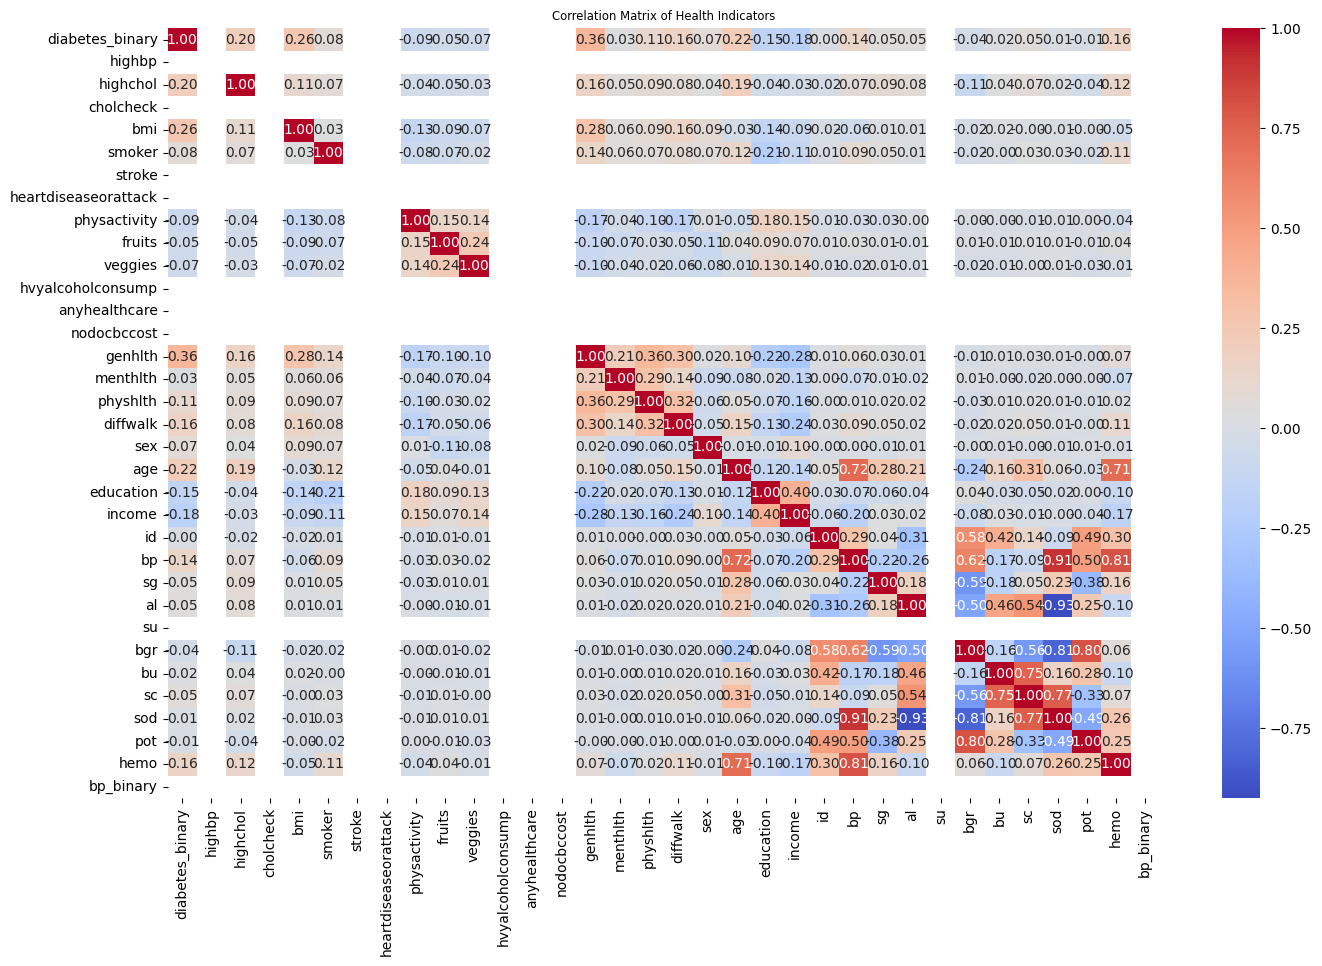

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the correlation matrix
correlation_matrix = cleaned_data.corr()

# Plotting the correlation matrix using a heatmap with improved formatting
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Rotate the y-axis labels to be horizontal
plt.yticks(rotation=0)

# Adjust the font size of annotations for better readability
sns.set(font_scale=0.7)

plt.title('Correlation Matrix of Health Indicators')
plt.show()


### 4-2. Data Visualization

Next, we create a series of visualizations to better understand and communicate our data. We'll look at distributions, trends, and relationships in the data.

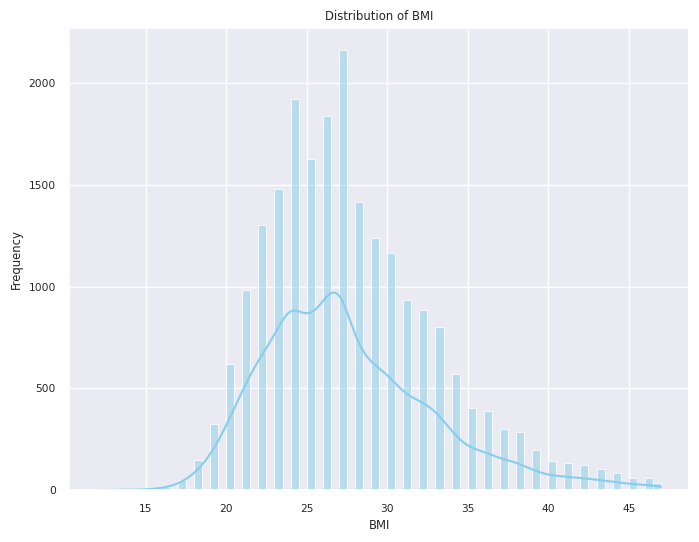

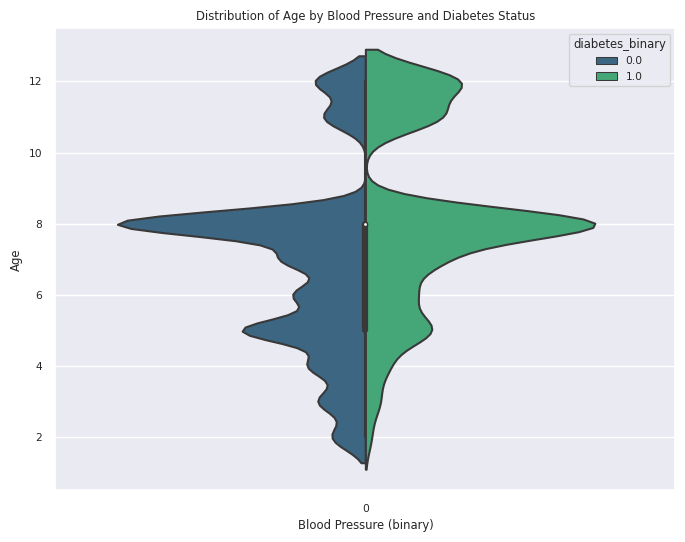

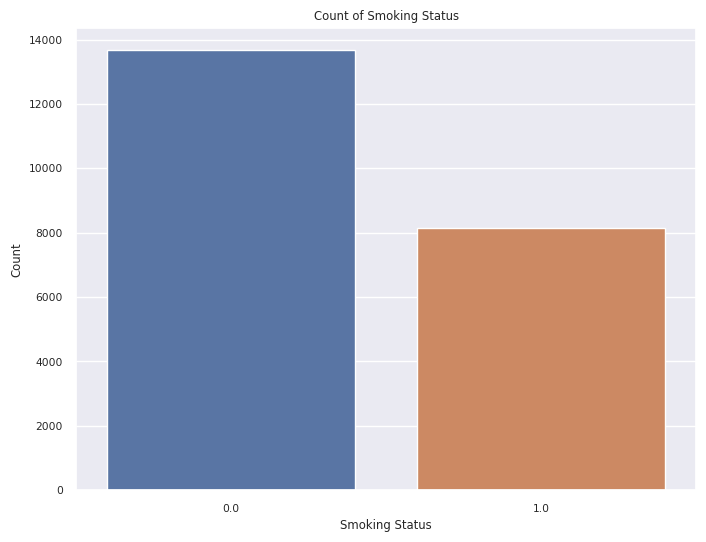

In [8]:
# Visualization 1: Distribution of BMI
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data['bmi'], kde=True, color='skyblue')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Age vs. Blood Pressure
plt.figure(figsize=(8, 6))
sns.violinplot(x='bp_binary', y='age', hue='diabetes_binary', data=cleaned_data, palette='viridis', split=True)
plt.title('Distribution of Age by Blood Pressure and Diabetes Status')
plt.xlabel('Blood Pressure (binary)')
plt.ylabel('Age')
plt.show()

# Visualization 3: Smoking Status Count
plt.figure(figsize=(8, 6))
sns.countplot(x='smoker', data=cleaned_data)
plt.title('Count of Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

## 5. Predictive Modeling

In this section, we focus on building a predictive model. This model will help us understand how various factors contribute to the risk of diabetes and kidney disease. We'll use regression analysis for this purpose, which is suitable for predicting numerical outcomes.

### 5-1. Regression Analysis

We will develop a regression model to predict a health outcome, such as the likelihood of having diabetes, based on various health indicators. The model's effectiveness will be evaluated using appropriate metrics.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Load your data into a DataFrame
# cleaned_data = pd.read_csv('your_dataset.csv')

# Define your features and target variable
X = cleaned_data.drop('diabetes_binary', axis=1)  # Features
y = cleaned_data['diabetes_binary']               # Target variable

# Identifying categorical columns that need to be encoded
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Identifying numerical columns for imputation
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creating a ColumnTransformer to apply OneHotEncoding to the categorical features and imputation to the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ], remainder='passthrough')

# Creating a pipeline that first transforms the data and then fits the regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = pipeline.predict(X_test)

# Evaluating the model with various metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
explained_variance = explained_variance_score(y_test, y_pred)

# Printing out the metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')
print(f'Explained Variance Score: {explained_variance}')


Mean Squared Error: 0.14293346392403938
Mean Absolute Error: 0.29864978435140427
R-squared: 0.1943340251526744
Adjusted R-squared: 0.1855585209075239
Explained Variance Score: 0.19433410401096907


## 6. Problem Applicability

The insights derived from this analysis have significant applicability in healthcare, particularly in understanding and managing diabetes and kidney disease. For instance, identifying key risk factors can aid in early diagnosis and preventive care strategies. Additionally, this analysis can inform public health policies and patient education programs.

## 7. Conclusion

This notebook presented a comprehensive analysis of diabetes and kidney disease data, highlighting the importance of data-driven decision-making in healthcare. Through data merging, transformation, visualization, and predictive modeling, we gained valuable insights that can contribute to better healthcare outcomes.